In [1]:

#load standard libraries and set graphing styles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from glob import glob
import  struct 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import norm
 

large = 18
med = 18
small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid')


 
from array import array

def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    baseTime=os.path.getctime(filename)
    distance=[]
    times=[]
    velocity=[]
    distances=[]
    data = array('B')
    isSpectroscopy=False
    bufferLabels = []
    bufferUnits =[]
    xPixels = 256
    yPixels = 256   
    xLength = 1
    yLength = 1
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n' and d!='data          BINARY_32\n':
            d=file1.readline()
            
            d=d.decode('ascii')
            dd=d.strip().split(' ')
             
            if len(dd)>1 and dd[-1]=='Spectroscopy':
                isSpectroscopy=True
            if dd[0]=='xPixels':
                xPixels=int(dd[-1])
            if dd[0]=='yPixels':
                yPixels=int(dd[-1])
            if dd[0]=='xLength':
                xLength=float(dd[-1])
            if dd[0]=='yLength':
                yLength=float(dd[-1])
            if dd[0]=='bufferLabel':
                bufferLabels.append(" ".join(dd[1:]).strip())
            if dd[0]=='bufferUnit':
                bufferUnits.append(" ".join(dd[1:]).strip())
            if dd[0]=='dateModified':
                ts = " ".join(dd[1:]).strip()
                ts=pd.to_datetime(ts, infer_datetime_format=True)
                ts=ts.value/1000000000
                #if np.abs(ts-baseTime)>10:
                #    baseTime=ts
                    
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
                
            if  d.startswith('chunk'):
                parts = d.split('\t')
                dist=float(parts[5])
                time0=float(parts[2])
                time=float(parts[3])
                valueO=float(parts[4])
                chunks.append({'points':int(parts[1]),
                               'distperpoint':dist, 
                               'timeperpoint':time,
                               'startValue':valueO,
                               'time0':time0})

        

        
        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )

        if not isSpectroscopy:
            print('load image', len(bufferLabels), xPixels,yPixels)
            images = []
            cc=0
            for i in range(0,len(bufferLabels)):
                img = np.zeros((xPixels,yPixels))
                print('image',i)
                for j in range(0,xPixels):
                    for k in range(0,yPixels):
                        img[j,k] = struct.unpack('<f', data[cc:cc+4])[0]
                        cc+=4
                images.append({ 'img':img ,
                                'label':bufferLabels[i],
                                'unit':bufferUnits[i],
                                'bias':bias,
                                'width':xLength,
                                'height':yLength  
                               })
            return images
        else:
            i=0
            while True:
                    cDist=0
                    for chunk in chunks:
                        chunkDist=[]
                        chunkCurrent=[]
                        
                        if isSpectroscopy:
                            cDist=chunk['startValue']
                            

                        for j in range(0,chunk['points']):
                            try:
                                f=(struct.unpack('<f', data[i:i+4]))
                            except:
                                return distance,current,bias,times,np.array(velocity) ,np.array(distances),bufferLabels,bufferUnits
                            chunkCurrent.append(f)
                            cDist+=chunk['distperpoint']
                            chunkDist.append(cDist)
                            i+=4
                    
                        dist=np.array(chunkDist)
                        if len(dist)>0:
                            distance.append(dist)
                            current.append(np.array(chunkCurrent).ravel()) 
                            totalTime=len(chunkDist)*chunk['timeperpoint']
                            time= chunk['time0']+ np.linspace(0, totalTime, len(chunkDist))
                        
                            times.append(time )
                            if len(dist)>0:
                                distances.append((dist[0]-dist[-1]))
                                velocity.append((dist[0]-dist[-1])/(time[0]-time[-1]))
            
    
    

file = r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240621_C11\C_11_OldTip_240621_134321.mi'  
#for file in dataFiles:
#    print(file)
#distance,currents,bias,times,velocity,distances,bufferLabels,bufferUnits=loadMI(file)
    #break
imagas =loadMI(file) 

#print(len(distance))
 

C:\Users\bashc\AppData\Local\Temp\ipykernel_23748\344366074.py:76: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


load image 4 256 256
image 0
image 1
image 2
image 3


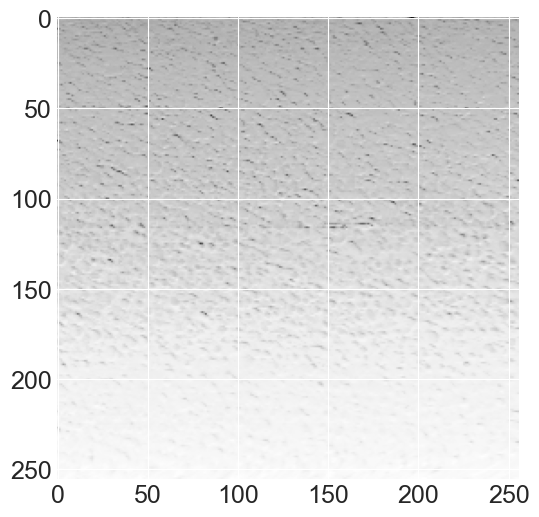

In [9]:
plt.imshow(imagas[3]['img'])

In [3]:
file =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\env_chamber_240715_135155.mi'
distance,currents,bias,times,velocity,distances=loadMI(file)
for j in range(0,len(distance)):
    if j==0:
        label ="Approach"
        min = currents[j][0]
    else:
        label="Retract"
    plt.plot(distance[j]*1e9,(currents[j]-min)*9.5*3,label=label)
    
plt.legend()    
plt.ylim([-150,20])
plt.xlabel('Piezo Distance (nm)')
plt.ylabel('Force (nN)')    
plt.show()

C:\Users\bashc\AppData\Local\Temp\ipykernel_23748\344366074.py:76: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


ValueError: too many values to unpack (expected 6)

In [3]:
#use saveoy gol to filter and smooth the data
from scipy.signal import savgol_filter
path=r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240621_C11'

desiredFiles = glob(path + r"\*.mi", recursive=False)
desiredPattern = ''
#desiredFiles = [file for file in desiredFiles if desiredPattern in file]
desiredFiles = sorted(desiredFiles)

cc=0
targetFiles = []
for file in desiredFiles:
    try:
        distance,currents,bias,times,velocity,distances,bufferLabels,bufferUnits=loadMI(file)
    except:
        continue
    if (bufferLabels[0]=='Distance' and bufferLabels[1]== 'CSAFM/Aux_BNC'):
        targetFiles.append(file)



C:\Users\bashc\AppData\Local\Temp\ipykernel_49244\463195558.py:35: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


In [8]:
dist 

array([], dtype=float64)

C:\Users\bashc\AppData\Local\Temp\ipykernel_49244\463195558.py:35: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


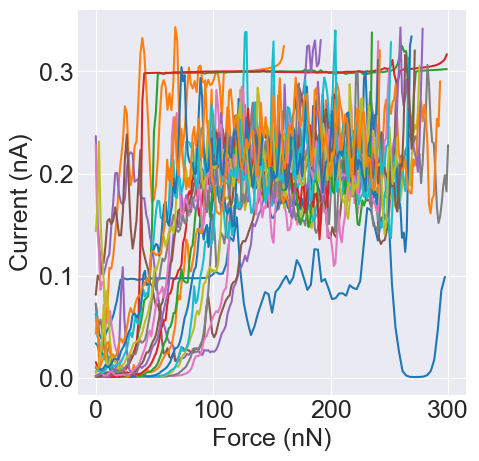

In [21]:
plt.figure(figsize=(5,5))
for file in targetFiles:
    distance,currents,bias,times,velocity,distances,bufferLabels,bufferUnits=loadMI(file)
    for j in range(0,len(distance)):
        if j==0:
            label ="Approach"
            min = currents[j][0]
        else:
            label="Retract"
        current= (currents[j]-min)*9.5*3
        ind=np.argsort(distance[j])
        dist = distance[j][ind]
        current = current[ind]
        #plt.plot(dist*1e9,current,label=label)
        cut = np.where( current>100)
        if len(cut[0])>0:
            cut=cut[0][0]
            current = current[:cut]
            dist=dist [:cut]
            if len(dist)>0 and np.min(current)<5:
                dist = (dist-dist[0])*1e9

                cut2= np.where( dist>100)
                if len(cut2[0])>0:
                    cut2=cut2[0][0]
                    current = current[:cut2]
                    dist=dist [:cut2]
            
                plt.plot((dist )*3,current/9.5/30,label=label)

plt.xlabel('Force (nN)')                 
plt.ylabel('Current (nA)')
plt.show()

In [45]:
res = 256
grid = np.zeros((res,res))
#load the all the npy files from the directory
folder = r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240702 CTPR8 NT\NIData\20240702_cTPR8_NewTip'
folder =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240703_CTPR4\NIData\20240703_C4'
folder =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240703_C9_Repeat_NewTip\NIData\20240703_C9_NewTip'
files = glob(folder + r"\*.npy", recursive=False)
data = []
cc=0

xRange=60
highF=.3
lowF=.1
for file in files:
    currents = np.load(file)
    current = currents[1]
    force = currents[0]
    #plt.plot(current)
    #plt.plot(force)
    #plt.show()
    #cc+=1
    #if cc>30:
    #   break

    if np.min(force[0])<lowF and np.max(force[-1])>highF:
        nmPPoint=  13.33*(highF-lowF)/len( force[ (force>lowF) & (force<highF)])  #nm/point
        cut = np.argwhere( current>.3)
         
        if len(cut)>0:
             
            cut=cut[:,0]
            current=np.abs(current[:(cut[0]+10)])
            force=force[:(cut[0]+10)]
            cutForce = np.argwhere( force>.5)
            if len(cutForce)>0:
               
                x=np.linspace(0,len(current)*nmPPoint,len(current))
                xx=x-x[cutForce[0]]+10

                #plt.plot(xx,current)

                #early = current[xx<2]
                #if len(early)>10:
                #    early = np.max( early)
                #    if early<.1:
                if True:
                        #plt.ylim([-0.5,1.5])
                        for j in range(len(xx)):
                            x=xx[j]
                            I=current[j]
                            x=int(x/xRange*res)
                            y=res-int(current[j]/.3*res)
                            if x>0 and x<res and y>0 and y<res:
                                grid[y,x]+=1
                #if cc>10:
                #    break
                
                cc+=1

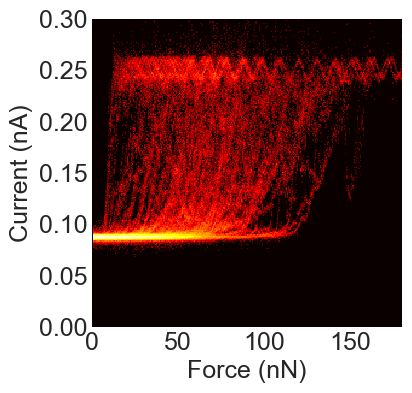

In [ ]:
plt.figure(figsize=(4,4))
 
plt.imshow(np.log(1+grid), cmap='hot', extent=[0,xRange*3,0,.3],aspect='auto', interpolation='nearest')       
plt.grid(None)
plt.xlabel('Force (nN)')
plt.ylabel('Current (nA)')
plt.show()

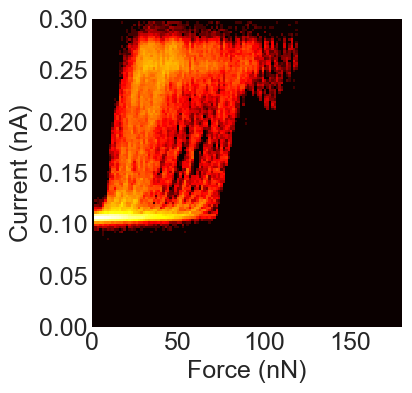

In [ ]:
plt.figure(figsize=(4,4))
 
plt.imshow(np.log(1+grid), cmap='hot', extent=[0,xRange*3,0,.3],aspect='auto', interpolation='nearest')       
plt.grid(None)
plt.xlabel('Force (nN)')
plt.ylabel('Current (nA)')
plt.show()

In [70]:
np.log(.001)/np.log(.99)

687.3158648300827